In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as bplt
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import requests

import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, r2_score, confusion_matrix, average_precision_score, precision_recall_curve, auc, roc_curve,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from bs4 import BeautifulSoup

Mostrem la primera linia de les dades del fitxer per veure les variables que tenim 

In [2]:
climate = pd.read_csv("C:/Users/noape/OneDrive/Documentos/PracticaKaggle/archive (1)/climate_change_indicators.csv")
climate.head(1)

,ObjectId,Country,ISO2,ISO3,Indicator,Unit,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,...,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022
0,1,"Afghanistan, Islamic Rep. of",AF,AFG,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate Indicator...",...,1.281,0.456,1.093,1.555,1.54,1.544,0.91,0.498,1.327,2.012


Tenim els seguents atributs:
ObjectId: Identificador de cada país
Country	: País
ISO2: Codi ISO del país de 2 lletres
ISO3: Codi ISO del país de 3 lletres
Indicator: Descripció de la variable mesurada, canvi de la temperatura desde 1951 fins 1980
Unit: Unitat de càlcul de la temperatura
Source: Descripció completa de la font de les dades (organisme, any, llicència, URL…)
CTS_Code: Codi curt de la categoria/indicador
CTS_Name: Nom curt de l’indicador
CTS_Full_Descriptor: Nom complet de la categoria + subcategoria
F1961: Valor de l’indicador en un any concret. (en aquest cas 1961). Canvi de temperatura anual (en °C) respecte al període base 1951–1980.
Arriba fins a l'any 2022 (F2022)

In [3]:
#Mirem si totes les variables ens aporten informació o són iguals per a cada fila del fitxer i si es així eliminem la variable. 
def variable_es_constant(df, columna):
    return df[columna].nunique() == 1
columnes = list(climate.columns)
for columna in columnes:
    if variable_es_constant(climate, columna):
        climate = climate.drop(columns=[columna])


climate.head(1)

    


,ObjectId,Country,ISO2,ISO3,F1961,F1962,F1963,F1964,F1965,F1966,...,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022
0,1,"Afghanistan, Islamic Rep. of",AF,AFG,-0.113,-0.164,0.847,-0.764,-0.244,0.226,...,1.281,0.456,1.093,1.555,1.54,1.544,0.91,0.498,1.327,2.012


Podem veure que hi havia bastantes variables repetides en totes les files, per tant no ens aportaven informació útil. Hem decidit que seria interessant afegir una nova variable que sigui el continent del pais, anomenada Continent. Ho fem de la següent manera:


In [4]:
paisos_a_continent = {
    # Àfrica
    "Algeria": "Africa",
    "Angola": "Africa",
    "Benin": "Africa",
    "Botswana": "Africa",
    "Burkina Faso": "Africa",
    "Burundi": "Africa",
    "Cabo Verde": "Africa",
    "Cameroon": "Africa",
    "Central African Rep.": "Africa",
    "Chad": "Africa",
    "Comoros, Union of the": "Africa",
    "Congo, Dem. Rep. of the": "Africa",
    "Congo, Rep. of": "Africa",
    "Djibouti": "Africa",
    "Egypt, Arab Rep. of": "Africa",
    "Equatorial Guinea, Rep. of": "Africa",
    "Eritrea, The State of": "Africa",
    "Eswatini, Kingdom of": "Africa",
    "Ethiopia, The Federal Dem. Rep. of": "Africa",
    "Gabon": "Africa",
    "Gambia, The": "Africa",
    "Ghana": "Africa",
    "Guinea": "Africa",
    "Guinea-Bissau": "Africa",
    "Kenya": "Africa",
    "Lesotho, Kingdom of": "Africa",
    "Liberia": "Africa",
    "Libya": "Africa",
    "Madagascar, Rep. of": "Africa",
    "Malawi": "Africa",
    "Mali": "Africa",
    "Mauritania, Islamic Rep. of": "Africa",
    "Mauritius": "Africa",
    "Mayotte": "Africa",
    "Morocco": "Africa",
    "Mozambique, Rep. of": "Africa",
    "Namibia": "Africa",
    "Niger": "Africa",
    "Nigeria": "Africa",
    "Rwanda": "Africa",
    "São Tomé and Príncipe, Dem. Rep. of": "Africa",
    "Senegal": "Africa",
    "Seychelles": "Africa",
    "Sierra Leone": "Africa",
    "South Africa": "Africa",
    "South Sudan, Rep. of": "Africa",
    "Sudan": "Africa",
    "Tanzania, United Rep. of": "Africa",
    "Togo": "Africa",
    "Uganda": "Africa",
    "Western Sahara": "Africa",
    "Zambia": "Africa",
    "Zimbabwe": "Africa",
    "Somalia": "Africa",
    "Tunisia": "Africa",

    # Amèrica del Nord
    "Anguilla":  "America",
    "Antigua and Barbuda": "America",
    "Bahamas, The": "America",
    "Barbados": "America",
    "Belize": "America",
    "Canada": "America",
    "Costa Rica": "America",
    "Cuba": "America",
    "Dominica": "America",
    "Dominican Rep.": "America",
    "El Salvador": "America",
    "Greenland": "America",
    "Grenada": "America",
    "Guatemala": "America",
    "Haiti": "America",
    "Honduras": "America",
    "Jamaica": "America",
    "Mexico": "America",
    "Montserrat": "America",
    "Panama": "America",
    "Puerto Rico": "America",
    "St. Kitts and Nevis": "America",
    "St. Lucia": "America",
    "St. Vincent and the Grenadines": "America",
    "Trinidad and Tobago": "America",
    "United States": "America",
    "United States Virgin Islands": "America",
    "British Virgin Islands": "America",
    "Cayman Islands": "America",
    "Guadeloupe": "America",
    "Martinique": "America",
    "Turks and Caicos Islands": "America", 

    # Amèrica del Sud
    "Argentina": "America",
    "Bolivia": "America",
    "Brazil": "America",
    "Chile": "America",
    "Colombia": "America",
    "Ecuador": "America",
    "Guyana": "America",
    "Paraguay": "America",
    "Peru": "America",
    "Suriname": "America",
    "Uruguay": "America",
    "Venezuela, Rep. Bolivariana de": "America",
    "Nicaragua": "America",
    

    # Europa
    "Albania": "Europe",
    "Andorra, Principality of": "Europe",
    "Armenia, Rep. of": "Europe",
    "Austria": "Europe",
    "Aruba, Kingdom of the Netherlands": "Europe",
    "Azerbaijan, Rep. of": "Europe",
    "Belarus, Rep. of": "Europe",
    "Belgium": "Europe",
    "Bosnia and Herzegovina": "Europe",
    "Bulgaria": "Europe",
    "Croatia, Rep. of": "Europe",
    "Cyprus": "Europe",
    "Czech Rep.": "Europe",
    "Denmark": "Europe",
    "Estonia, Rep. of": "Europe",
    "Faroe Islands": "Europe",
    "Finland": "Europe",
    "France": "Europe",
    "Georgia": "Europe",
    "Germany": "Europe",
    "Gibraltar": "Europe",
    "Greece": "Europe",
    "Holy See": "Europe",
    "Hungary": "Europe",
    "Iceland": "Europe",
    "Ireland": "Europe",
    "Isle of Man": "Europe",
    "Italy": "Europe",
    "Kazakhstan, Rep. of": "Europe",
    "Latvia": "Europe",
    "Liechtenstein": "Europe",
    "Lithuania": "Europe",
    "Luxembourg": "Europe",
    "Malta": "Europe",
    "Monaco": "Europe",
    "Montenegro": "Europe",
    "Netherlands, The": "Europe",
    "North Macedonia, Republic of ": "Europe",
    "Norway": "Europe",
    "Poland, Rep. of": "Europe",
    "Portugal": "Europe",
    "Romania": "Europe",
    "Russian Federation": "Europe",
    "San Marino, Rep. of": "Europe",
    "Serbia, Rep. of": "Europe",
    "Slovak Rep.": "Europe",
    "Slovenia, Rep. of": "Europe",
    "Spain": "Europe",
    "Sweden": "Europe",
    "Switzerland": "Europe",
    "Ukraine": "Europe",
    "United Kingdom": "Europe",
    "Moldova, Rep. of": "Europe",

    # Àsia
    "Afghanistan, Islamic Rep. of": "Asia",
    "Bahrain, Kingdom of": "Asia",
    "Bangladesh": "Asia",
    "Bhutan": "Asia",
    "Brunei Darussalam": "Asia",
    "Cambodia": "Asia",
    "China, P.R.: Hong Kong": "Asia",
    "China, P.R.: Macao": "Asia",
    "China, P.R.: Mainland": "Asia",
    "India": "Asia",
    "Indonesia": "Asia",
    "Iran, Islamic Rep. of": "Asia",
    "Iraq": "Asia",
    "Israel": "Asia",
    "Japan": "Asia",
    "Jordan": "Asia",
    "Korea, Dem. People's Rep. of": "Asia",
    "Korea, Rep. of": "Asia",
    "Kuwait": "Asia",
    "Kyrgyz Rep.": "Asia",
    "Lao People's Dem. Rep.": "Asia",
    "Lebanon": "Asia",
    "Malaysia": "Asia",
    "Maldives": "Asia",
    "Mongolia": "Asia",
    "Myanmar": "Asia",
    "Nepal": "Asia",
    "Oman": "Asia",
    "Pakistan": "Asia",
    "Philippines": "Asia",
    "Qatar": "Asia",
    "Saudi Arabia": "Asia",
    "Singapore": "Asia",
    "Sri Lanka": "Asia",
    "Syrian Arab Rep.": "Asia",
    "Taiwan Province of China": "Asia",
    "Tajikistan, Rep. of": "Asia",
    "Thailand": "Asia",
    "Timor-Leste, Dem. Rep. of": "Asia",
    "Turkmenistan": "Asia",
    "United Arab Emirates": "Asia",
    "Uzbekistan, Rep. of": "Asia",
    "Vietnam": "Asia",
    "Yemen, Rep. of": "Asia",
    "West Bank and Gaza":"Asia",

    # Oceania
    "American Samoa": "Oceania",
    "Australia": "Oceania",
    "Cook Islands": "Oceania",
    "Fiji, Rep. of": "Oceania",
    "Kiribati": "Oceania",
    "Marshall Islands, Rep. of the": "Oceania",
    "Micronesia, Federated States of": "Oceania",
    "Nauru, Rep. of": "Oceania",
    "New Caledonia": "Oceania",
    "New Zealand": "Oceania",
    "Niue": "Oceania",
    "Norfolk Island": "Oceania",
    "Palau, Rep. of": "Oceania",
    "Papua New Guinea": "Oceania",
    "Samoa": "Oceania",
    "Solomon Islands": "Oceania",
    "Tokelau": "Oceania",
    "Tonga": "Oceania",
    "Tuvalu": "Oceania",
    "Vanuatu": "Oceania",
    "Wallis and Futuna Islands": "Oceania",

    # Altres / regions especials
    "World": "Other",
    "Falkland Islands (Malvinas)": "Other",
    "French Polynesia": "Other",
    "Mayotte": "Other",
    "Pitcairn Islands": "Other",
    "Saint Helena": "Other",
    "Saint Pierre and Miquelon": "Other",
}


In [5]:
def afegeix_continent(climate, columna_pais='Country'):
    climate['Continent'] = climate[columna_pais].map(lambda x: paisos_a_continent.get(x, 'Desconegut'))
    return climate

climate = afegeix_continent(climate)
print(climate)


     ObjectId                       Country ISO2 ISO3  F1961  F1962  F1963  \
0           1  Afghanistan, Islamic Rep. of   AF  AFG -0.113 -0.164  0.847   
1           2                       Albania   AL  ALB  0.627  0.326  0.075   
2           3                       Algeria   DZ  DZA  0.164  0.114  0.077   
3           4                American Samoa   AS  ASM  0.079 -0.042  0.169   
4           5      Andorra, Principality of   AD  AND  0.736  0.112 -0.752   
..        ...                           ...  ...  ...    ...    ...    ...   
220       221                Western Sahara   EH  ESH  0.632  0.576  0.333   
221       222                         World  NaN  WLD  0.211  0.038  0.168   
222       223                Yemen, Rep. of   YE  YEM  0.029 -0.009  0.169   
223       224                        Zambia   ZM  ZMB  0.228 -0.168 -0.390   
224       225                      Zimbabwe   ZW  ZWE  0.267  0.237 -0.458   

     F1964  F1965  F1966  ...  F2014  F2015  F2016  F2017  F201

Ara podem analitzar la forma del dataset

In [6]:
print("El dataset té {} files i {} columnes".format(len(climate),len(climate.columns)))

El dataset té 225 files i 67 columnes


In [7]:
# Comprovant la mitjana, la mediana, la desviació estàndard i els percentils de les característiques numèriques del conjunt de dades
climate.describe()

,ObjectId,F1961,F1962,F1963,F1964,F1965,F1966,F1967,F1968,F1969,...,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022
count,225.000000,188.000000,189.000000,188.000000,188.000000,188.000000,192.000000,191.000000,191.000000,190.000000,...,216.000000,216.000000,216.000000,213.000000,214.000000,213.000000,213.000000,212.000000,213.000000,213.000000
mean,113.000000,0.163053,-0.013476,-0.006043,-0.070059,-0.247027,0.105505,-0.110832,-0.199110,0.157942,...,0.931199,1.114815,1.269773,1.439521,1.280785,1.302113,1.443061,1.552038,1.343531,1.382113
std,65.096083,0.405080,0.341812,0.387348,0.309305,0.270734,0.378423,0.339484,0.270131,0.308540,...,0.321595,0.564903,0.462162,0.401091,0.393999,0.596786,0.467510,0.621930,0.484692,0.669279
min,1.000000,-0.694000,-0.908000,-1.270000,-0.877000,-1.064000,-1.801000,-1.048000,-1.634000,-0.900000,...,0.118000,-0.092000,-0.430000,0.250000,0.017000,0.238000,0.050000,0.229000,-0.425000,-1.305000
25%,57.000000,-0.097000,-0.164000,-0.205500,-0.236500,-0.392500,-0.035750,-0.259500,-0.340000,-0.009000,...,0.743500,0.744000,1.017750,1.147000,1.027500,0.865000,1.169000,1.161750,1.019000,0.878000
50%,113.000000,0.064500,-0.056000,-0.003000,-0.056000,-0.230500,0.098000,-0.146000,-0.187000,0.204000,...,0.897000,0.986500,1.215000,1.446000,1.282000,1.125000,1.412000,1.477000,1.327000,1.315000
75%,169.000000,0.318500,0.114000,0.230500,0.132500,-0.091500,0.277000,0.015000,-0.067000,0.349000,...,1.187500,1.335500,1.520500,1.714000,1.535000,1.834000,1.698000,1.826250,1.629000,1.918000
max,225.000000,1.892000,0.998000,1.202000,1.097000,0.857000,1.151000,1.134000,0.476000,0.939000,...,1.643000,2.704000,2.613000,2.459000,2.493000,2.772000,2.689000,3.691000,2.676000,3.243000


In [8]:
# Mirem els valors nulls del dataset
nan_columns = climate.columns[climate.isna().sum()>0].tolist() #columnes q falta 1 o més valors al datset
print('NÚMERO DE NANS PER COLUMNA:')
print (climate.loc[:,nan_columns].isna().sum()) #numero de nans per columna

NÚMERO DE NANS PER COLUMNA:
ISO2      2
F1961    37
F1962    36
F1963    37
F1964    37
         ..
F2018    12
F2019    12
F2020    13
F2021    12
F2022    12
Length: 63, dtype: int64


In [9]:
print('\nPERCENTATGES DE NANS PER COLUMNA:')
print (climate.loc[:,nan_columns].isna().sum()/len(climate)*100) #percentatge de nans per columna
print("\nNúmero de nans totals en el dataset:", climate.isna().sum().sum())


PERCENTATGES DE NANS PER COLUMNA:
ISO2      0.888889
F1961    16.444444
F1962    16.000000
F1963    16.444444
F1964    16.444444
           ...    
F2018     5.333333
F2019     5.333333
F2020     5.777778
F2021     5.333333
F2022     5.333333
Length: 63, dtype: float64

Número de nans totals en el dataset: 1492


Hem decidit eliminar les variables que tenen més de 35 NaNs ja que considerem que no ens aporten informació útil. Aquestes són:

In [10]:
data = pd.DataFrame(climate.isnull().sum()[climate.isnull().sum() > 30])
data

,0
F1961,37
F1962,36
F1963,37
F1964,37
F1965,37
F1966,33
F1967,34
F1968,34
F1969,35
F1970,36


In [11]:
climate = climate.loc[:, climate.isna().sum() <= 30]
climate
#per tant, ens quedem amb les dades a partir de l'any 1992

,ObjectId,Country,ISO2,ISO3,F1992,F1993,F1994,F1995,F1996,F1997,...,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,Continent
0,1,"Afghanistan, Islamic Rep. of",AF,AFG,-0.294,0.220,0.430,0.359,-0.116,0.471,...,0.456,1.093,1.555,1.540,1.544,0.910,0.498,1.327,2.012,Asia
1,2,Albania,AL,ALB,0.106,0.076,1.330,-0.172,-0.038,0.075,...,1.198,1.569,1.464,1.121,2.028,1.675,1.498,1.536,1.518,Europe
2,3,Algeria,DZ,DZA,-0.312,0.552,0.732,0.595,0.846,1.059,...,1.690,1.121,1.757,1.512,1.210,1.115,1.926,2.330,1.688,Africa
3,4,American Samoa,AS,ASM,0.344,-0.069,0.189,0.755,0.784,NaN,...,1.170,1.009,1.539,1.435,1.189,1.539,1.430,1.268,1.256,Oceania
4,5,"Andorra, Principality of",AD,AND,0.386,0.174,1.508,1.279,0.570,1.788,...,1.946,1.690,1.990,1.925,1.919,1.964,2.562,1.533,3.243,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,221,Western Sahara,EH,ESH,0.529,0.315,0.903,1.356,1.353,1.536,...,1.401,1.510,1.732,2.204,0.942,1.477,2.069,1.593,1.970,Africa
221,222,World,NaN,WLD,0.184,0.348,0.507,0.835,0.355,0.656,...,1.053,1.412,1.660,1.429,1.290,1.444,1.711,1.447,1.394,Other
222,223,"Yemen, Rep. of",YE,YEM,NaN,NaN,NaN,NaN,NaN,0.107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia
223,224,Zambia,ZM,ZMB,0.544,-0.117,0.362,0.761,0.393,0.339,...,0.917,1.450,1.401,0.105,0.648,0.855,0.891,0.822,0.686,Africa


In [12]:
#Encara així, seguim tenint 32 columnes amb valors nuls que hem d'omplir per fer el model més apropiat
nulls = pd.DataFrame(climate.isnull().sum()[climate.isnull().sum() > 0])
nulls.shape
#mirem quines variables tenen Nans i per tant hem d'omplir
nan_columns = climate.columns[climate.isna().sum()>0].tolist()
nan_columns

['ISO2',
 'F1992',
 'F1993',
 'F1994',
 'F1995',
 'F1996',
 'F1997',
 'F1998',
 'F1999',
 'F2000',
 'F2001',
 'F2002',
 'F2003',
 'F2004',
 'F2005',
 'F2006',
 'F2007',
 'F2008',
 'F2009',
 'F2010',
 'F2011',
 'F2012',
 'F2013',
 'F2014',
 'F2015',
 'F2016',
 'F2017',
 'F2018',
 'F2019',
 'F2020',
 'F2021',
 'F2022']

Per a les variables dels anys, hem decidit que omplirem els valors Nuls fent interpolació lineal amb l'any d'abans i l'any posterior al del valor Nul. Per a les variables no numèriques que tenen valors nuls que són ISO2 i ISO3, hem decidit omplir-ho com a 'Uknown' ja que no tenen ISO o només tenen un d'ells.

In [13]:
# Fem una còpia del DataFrame
climate_mod = climate.copy()

# Seleccionem només les columnes numèriques (del 5è fins a la penúltima)
cols_numeriques = climate_mod.columns[4:-1]

# Ens assegurem que siguin números
climate_mod[cols_numeriques] = climate_mod[cols_numeriques].apply(pd.to_numeric, errors='coerce')
# Interpolació horitzontal per files (cada país)
climate_mod[cols_numeriques] = climate_mod[cols_numeriques].interpolate(
    method='linear', axis=1, limit_direction='both'
)

climate_mod[climate_mod.select_dtypes(include=['object']).columns] = \
    climate_mod.select_dtypes(include=['object']).fillna('Unknown')
# El DataFrame final té les columnes no numèriques intactes i les numèriques interpolades
climate_mod


,ObjectId,Country,ISO2,ISO3,F1992,F1993,F1994,F1995,F1996,F1997,...,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,Continent
0,1,"Afghanistan, Islamic Rep. of",AF,AFG,-0.294,0.220,0.430,0.359,-0.116,0.471000,...,0.456,1.093,1.555,1.540,1.544,0.910,0.498,1.327,2.012,Asia
1,2,Albania,AL,ALB,0.106,0.076,1.330,-0.172,-0.038,0.075000,...,1.198,1.569,1.464,1.121,2.028,1.675,1.498,1.536,1.518,Europe
2,3,Algeria,DZ,DZA,-0.312,0.552,0.732,0.595,0.846,1.059000,...,1.690,1.121,1.757,1.512,1.210,1.115,1.926,2.330,1.688,Africa
3,4,American Samoa,AS,ASM,0.344,-0.069,0.189,0.755,0.784,0.603333,...,1.170,1.009,1.539,1.435,1.189,1.539,1.430,1.268,1.256,Oceania
4,5,"Andorra, Principality of",AD,AND,0.386,0.174,1.508,1.279,0.570,1.788000,...,1.946,1.690,1.990,1.925,1.919,1.964,2.562,1.533,3.243,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,221,Western Sahara,EH,ESH,0.529,0.315,0.903,1.356,1.353,1.536000,...,1.401,1.510,1.732,2.204,0.942,1.477,2.069,1.593,1.970,Africa
221,222,World,Unknown,WLD,0.184,0.348,0.507,0.835,0.355,0.656000,...,1.053,1.412,1.660,1.429,1.290,1.444,1.711,1.447,1.394,Other
222,223,"Yemen, Rep. of",YE,YEM,0.107,0.107,0.107,0.107,0.107,0.107000,...,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,Asia
223,224,Zambia,ZM,ZMB,0.544,-0.117,0.362,0.761,0.393,0.339000,...,0.917,1.450,1.401,0.105,0.648,0.855,0.891,0.822,0.686,Africa


In [14]:
print("Number of missing values after cleaning and filling is", climate_mod.isnull().sum().sum())
nulls = pd.DataFrame(climate_mod.isnull().sum()[climate_mod.isnull().sum() > 0])
#mirem quines paisos tenen Nans
climate_mod[climate_mod.isnull().any(axis=1)]
#print("Number of missing values after cleaning and filling is", climate.isnull().sum().sum())

Number of missing values after cleaning and filling is 62


,ObjectId,Country,ISO2,ISO3,F1992,F1993,F1994,F1995,F1996,F1997,...,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,Continent
65,66,Falkland Islands (Malvinas),FK,FLK,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
200,201,Tokelau,TK,TKL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oceania


Veiem que hi ha dos paisos que no tenen cap valor a les variables dels canvis de temperatura. Per tant, aquests dos els hem d'eliminar ja que no ens aporten cap informació útil.

In [15]:
climate_mod = climate_mod.drop(index=[65,200])
climate_mod.reset_index(drop=True, inplace=True)
print("Nombre de valors nuls amb el dataset modificat:", climate_mod.isnull().sum().sum())
climate=climate_mod

Nombre de valors nuls amb el dataset modificat: 0


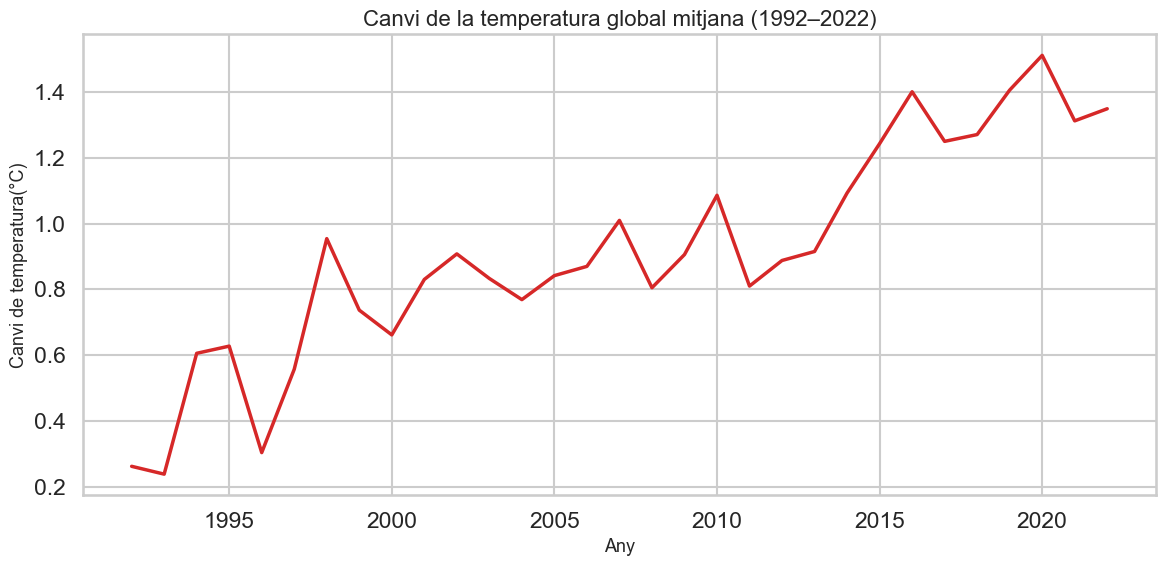

In [16]:
#Visualitzem les dades que tenim amb gràfiques

sns.set_theme(style="whitegrid", context="talk", palette="coolwarm")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["figure.facecolor"] = "white"


col_anys = [col for col in climate.columns if col.startswith("F")]
anys = climate[col_anys]

#Fem un gràfic de la temperatura global mitjana al llarg dels anys 1992-2022
global_anys = anys.mean()
temp_global = pd.DataFrame({"Any": [int(y[1:]) for y in col_anys], "Temperatura mitjana": global_anys.values})

plt.figure()
sns.lineplot(data=temp_global, x="Any", y="Temperatura mitjana", linewidth=2.5, color="#D62828")
plt.title("Canvi de la temperatura global mitjana (1992–2022)")
plt.xlabel("Any")
plt.ylabel("Canvi de temperatura(°C)")
plt.tight_layout()
plt.show()



Hem creat aquesta gràfica per observar com ha canviat la temperatura mitjana de tots els països al llarg del temps. Ajuda a identificar si el món s’està escalfant o refredant mostrant la direcció general del canvi de temperatura. Veiem una tendència creixent de la funció que indica un augment global de la temperatura, destacant l’impacte del canvi climàtic durant les últimes tres dècades.

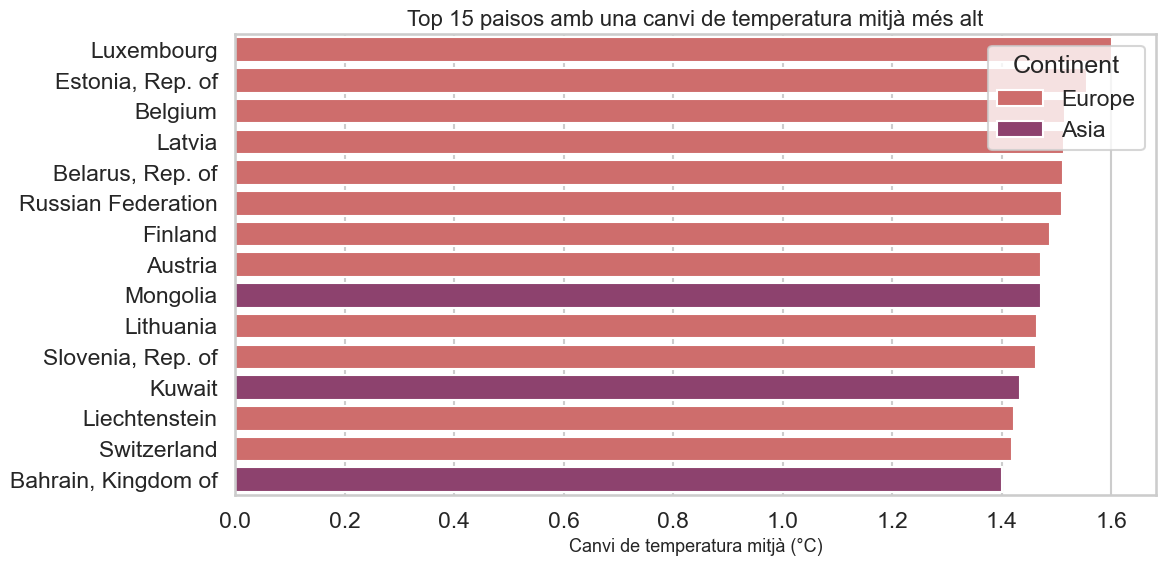

In [17]:
#Observem els 15 paisos amb una canvi de temperatura mitjà més alt, amb els seus respectius continents
climate["Mean"] = anys.mean(axis=1) 
top = climate.nlargest(15, "Mean")

plt.figure()
sns.barplot(data=top, y="Country", x="Mean", hue="Continent", palette="flare")
plt.title("Top 15 paisos amb una canvi de temperatura mitjà més alt")
plt.xlabel("Canvi de temperatura mitjà (°C)")
plt.ylabel("")
plt.tight_layout()
plt.show()


Podem veure que principalment apareixen països que pertanyen a Europa, els 8 primers paisos amb un canvi de temperatura més alt pertanyen a Europa. Aquests resultats ens indiquen que el canvi climàtic pot estar afectant més al continent Europeu que als altres.

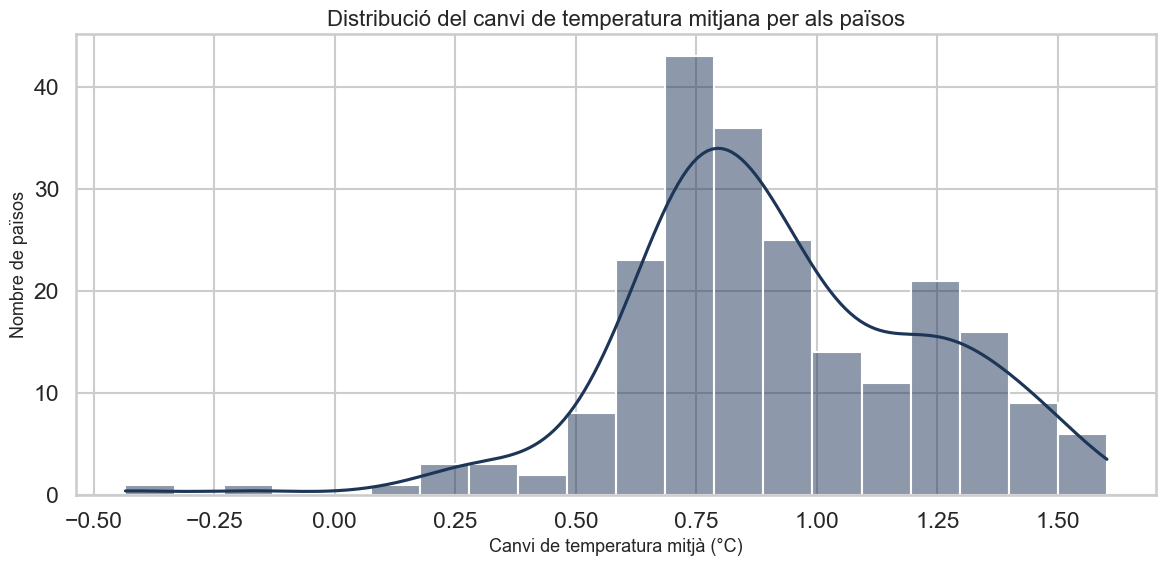

In [18]:
#Distribucio del canvi de temperatura
plt.figure()
sns.histplot(climate["Mean"], bins=20, kde=True, color="#1D3557")
plt.title("Distribució del canvi de temperatura mitjana per als països")
plt.xlabel("Canvi de temperatura mitjà (°C)")
plt.ylabel("Nombre de països")
plt.tight_layout()
plt.show()


Veiem que clarament la majoria de paisos tenen un canvi de temperatura mitjà al voltant de 0.75, no és un canvi molt extrem però tampoc despreciable. 
Hem decidit que és una bona idea comparar com va canviar la temperatura abans del 2000 i després, per veure si el canvi augmenta al llarg dels anys o si es manté més o menys constant. 

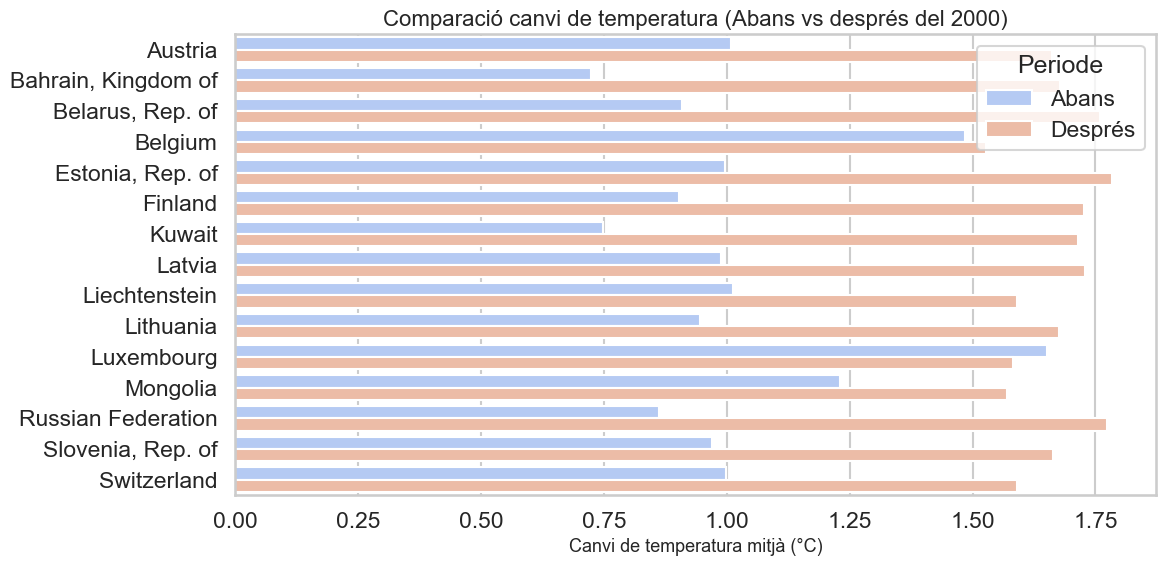

In [19]:
abans = [col for col in col_anys if int(col[1:]) <= 2000]
despres = [col for col in col_anys if int(col[1:]) > 2000]

climate["Abans"] = climate[abans].mean(axis=1)
climate["Després"] = climate[despres].mean(axis=1)
#Fem la comparació amb els 15 paisos amb més canvi de temperatura mitjà
comparison = climate[["Country", "Abans", "Després"]].melt(id_vars="Country", 
                                                             var_name="Period", 
                                                             value_name="AvgTempChange")
top15_comp = comparison[comparison["Country"].isin(top["Country"])]

plt.figure()
sns.barplot(data=top15_comp, x="AvgTempChange", y="Country", hue="Period", palette="coolwarm")
plt.title("Comparació canvi de temperatura (Abans vs després del 2000)")
plt.xlabel("Canvi de temperatura mitjà (°C)")
plt.ylabel("")
plt.legend(title="Periode")
plt.tight_layout()
plt.show()


Aquest diagrama de barres compara el canvi de temperatura mitjana abans i després de l’any 2000 per als 15 països principals. Mostra visualment com ha canviat la temperatura al llarg del temps, indicant quines regions van experimentar l’augment més significatiu de temperatura després del 2000. En comparar els dos períodes, es veu clarament l’impacte creixent del canvi climàtic.

A continuació fem la matriu de correlació per visualitzar la relació entre els canvis de temperatura al llarg dels anys.

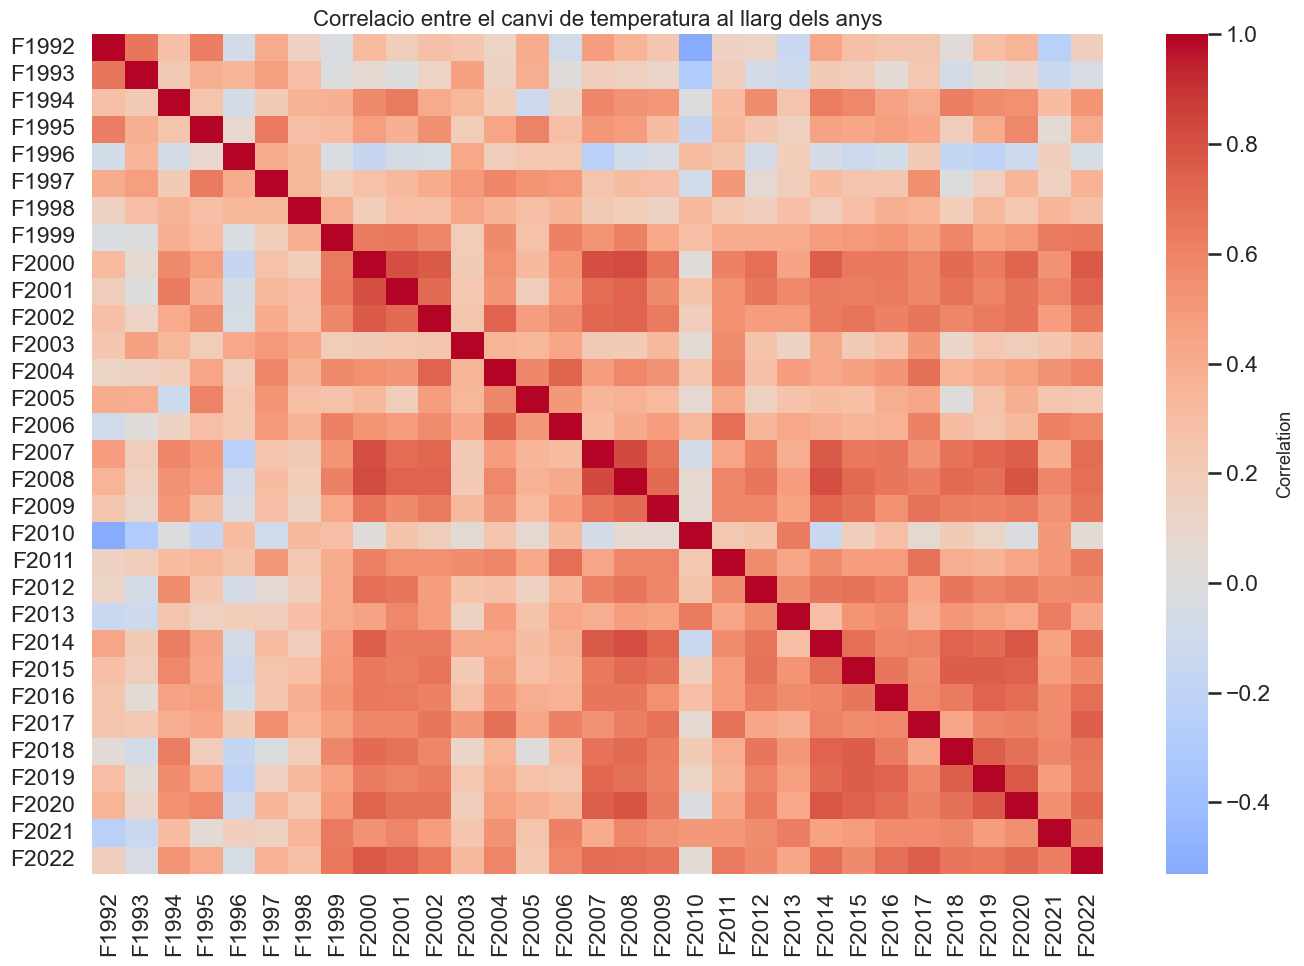

In [20]:
corr = anys.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={'label': 'Correlation'})
plt.title("Correlacio entre el canvi de temperatura al llarg dels anys")
plt.tight_layout()
plt.show()

Cada cel·la representa la força de la correlació entre les temperatures d’un any i les d’un altre. Les correlacions altes (mostrades amb colors més càlids) indiquen tendències constants d’escalfament global al llarg del temps, mentre que les correlacions més baixes revelen períodes de variació irregular de la temperatura. Aquest mapa de calor ajuda a identificar patrons climàtics a llarg termini i dependències temporals en les dades de canvi de temperatura global.

Finalment, hem decidit mostrar els continents de més a menys canvid de temperatura mitjà.


C:\Users\noape\AppData\Local\Temp\ipykernel_19136\1296971494.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


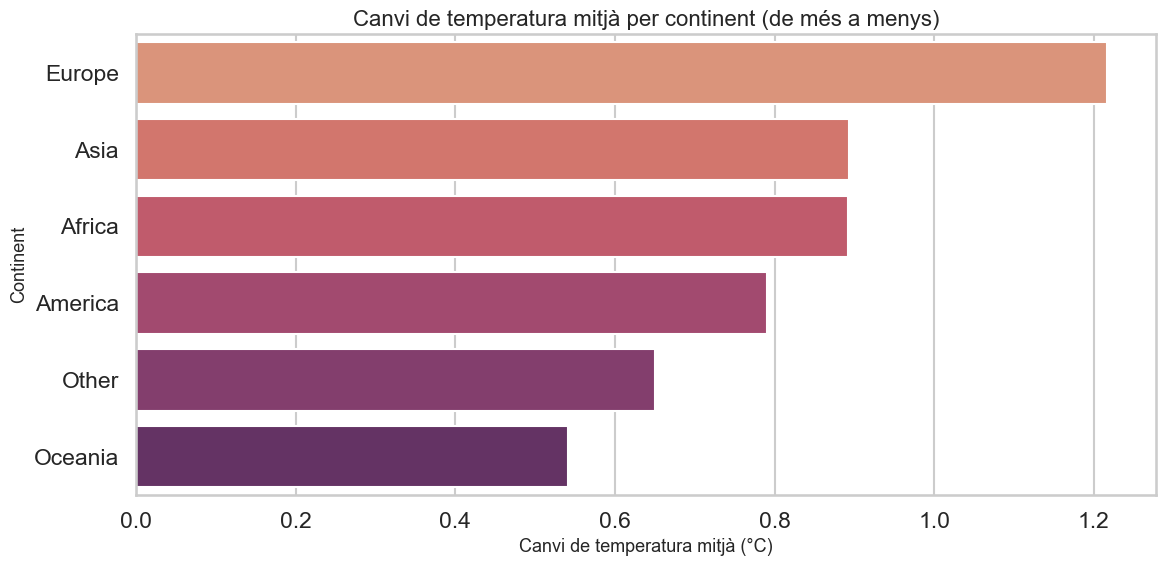

In [21]:
# Agrupem per continent i fem la mitjana del canvi
cont_canvi = (
    climate.groupby("Continent")["Mean"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Fem el gràfic
plt.figure()
sns.barplot(
    data=cont_canvi,
    x="Mean",
    y="Continent",
    palette="flare"
)

plt.title("Canvi de temperatura mitjà per continent (de més a menys)")
plt.xlabel("Canvi de temperatura mitjà (°C)")
plt.ylabel("Continent")
plt.tight_layout()
plt.show()

Tal com haviem vist anteriorment, Europa presenta una diferència amb la resta de continents. És el continent amb un canvi de temperatura mitjà més alt, mentres que Oceania es el continent que presenta un canvi inferior, i per tant, l'impacte del canvi climàtic no és tan elevat.